In [2]:
import os
import cv2
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt


In [3]:
path = kagglehub.dataset_download("rkuo2000/uecfood256")
!cp -r /root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1 /content/dataset
print("Path to dataset files:", path)

100%|██████████| 3.94G/3.94G [00:52<00:00, 80.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1


In [4]:
def load_bounding_boxes(data_dir):
    bounding_boxes = {}

    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        if not os.path.isdir(folder_path):
            continue

        bb_file = os.path.join(folder_path, 'bb_info.txt')

        if os.path.exists(bb_file):
            print(f"bb_info.txt ditemukan di folder {folder_name}")

            with open(bb_file, 'r') as file:
                folder_bounding_boxes = {}
                for line in file:
                    parts = line.strip().split()

                    if parts[0] == 'img':
                        continue

                    img_num, x1, y1, x2, y2 = map(int, parts)
                    folder_bounding_boxes[img_num] = (x1, y1, x2, y2)

                bounding_boxes[folder_name] = folder_bounding_boxes
        else:
            print(f"bb_info.txt tidak ditemukan di folder {folder_name}")

    return bounding_boxes

def crop_and_save_images(data_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_bounding_boxes = load_bounding_boxes(data_dir)

    for category, bounding_boxes in all_bounding_boxes.items():
        category_path = os.path.join(data_dir, category)

        category_output_path = os.path.join(output_dir, category)
        os.makedirs(category_output_path, exist_ok=True)

        for img_num, bbox in bounding_boxes.items():
            img_path = os.path.join(category_path, f"{img_num}.jpg")

            if not os.path.exists(img_path):
                print(f"Gambar {img_num}.JPG tidak ditemukan di folder {category}")
                continue

            x1, y1, x2, y2 = bbox
            image = cv2.imread(img_path)
            if image is None:
                print(f"Gagal membaca gambar {img_num}.JPG di folder {category}")
                continue

            cropped_image = image[y1:y2, x1:x2]

            output_img_path = os.path.join(category_output_path, f"{img_num}.JPG")
            cv2.imwrite(output_img_path, cropped_image)
            print(f"Gambar {img_num}.JPG berhasil disimpan ke {output_img_path}")

# Path data dan output
data_dir = "/content/dataset/UECFOOD256"
output_dir = "/content/dataset/new_UECFOOD256"

crop_and_save_images(data_dir, output_dir)


Streaming output truncated to the last 5000 lines.
Gambar 133634.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/133634.JPG
Gambar 139339.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/139339.JPG
Gambar 139382.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/139382.JPG
Gambar 315261.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/315261.JPG
Gambar 180530.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/180530.JPG
Gambar 314359.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/314359.JPG
Gambar 133658.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/133658.JPG
Gambar 266235.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/266235.JPG
Gambar 314350.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/314350.JPG
Gambar 266202.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/266202.JPG
Gambar 314461.JPG berhasil disimpan ke /content/dataset/new_UECFOOD256/198/314461.JPG
Gam

In [5]:
import shutil

source_dir = output_dir
subset_dir = '/content/dataset/pppp'

os.makedirs(subset_dir, exist_ok=True)

classes = sorted(os.listdir(source_dir))[:64]
selected_classes = ['23', '87', '6', '17','68','12']
for class_name in selected_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(subset_dir, class_name)
    shutil.copytree(class_path, target_path)

print("Subset dataset selesai dibuat.")


Subset dataset selesai dibuat.


In [6]:
def count_images_in_folders(base_dir):
    folder_counts = {}
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_counts[folder_name] = num_images
    return folder_counts

base_directory = subset_dir
image_counts = count_images_in_folders(base_directory)

for folder, count in image_counts.items():
    print(f"Folder '{folder}' contains {count} images.")


Folder '87' contains 342 images.
Folder '17' contains 233 images.
Folder '68' contains 224 images.
Folder '6' contains 246 images.
Folder '12' contains 218 images.
Folder '23' contains 353 images.


In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(160, 160),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(160, 160),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

# Accessing the class indices
class_labels = train_data.class_indices
print(class_labels)


Found 1296 images belonging to 6 classes.
Found 320 images belonging to 6 classes.
{'12': 0, '17': 1, '23': 2, '6': 3, '68': 4, '87': 5}


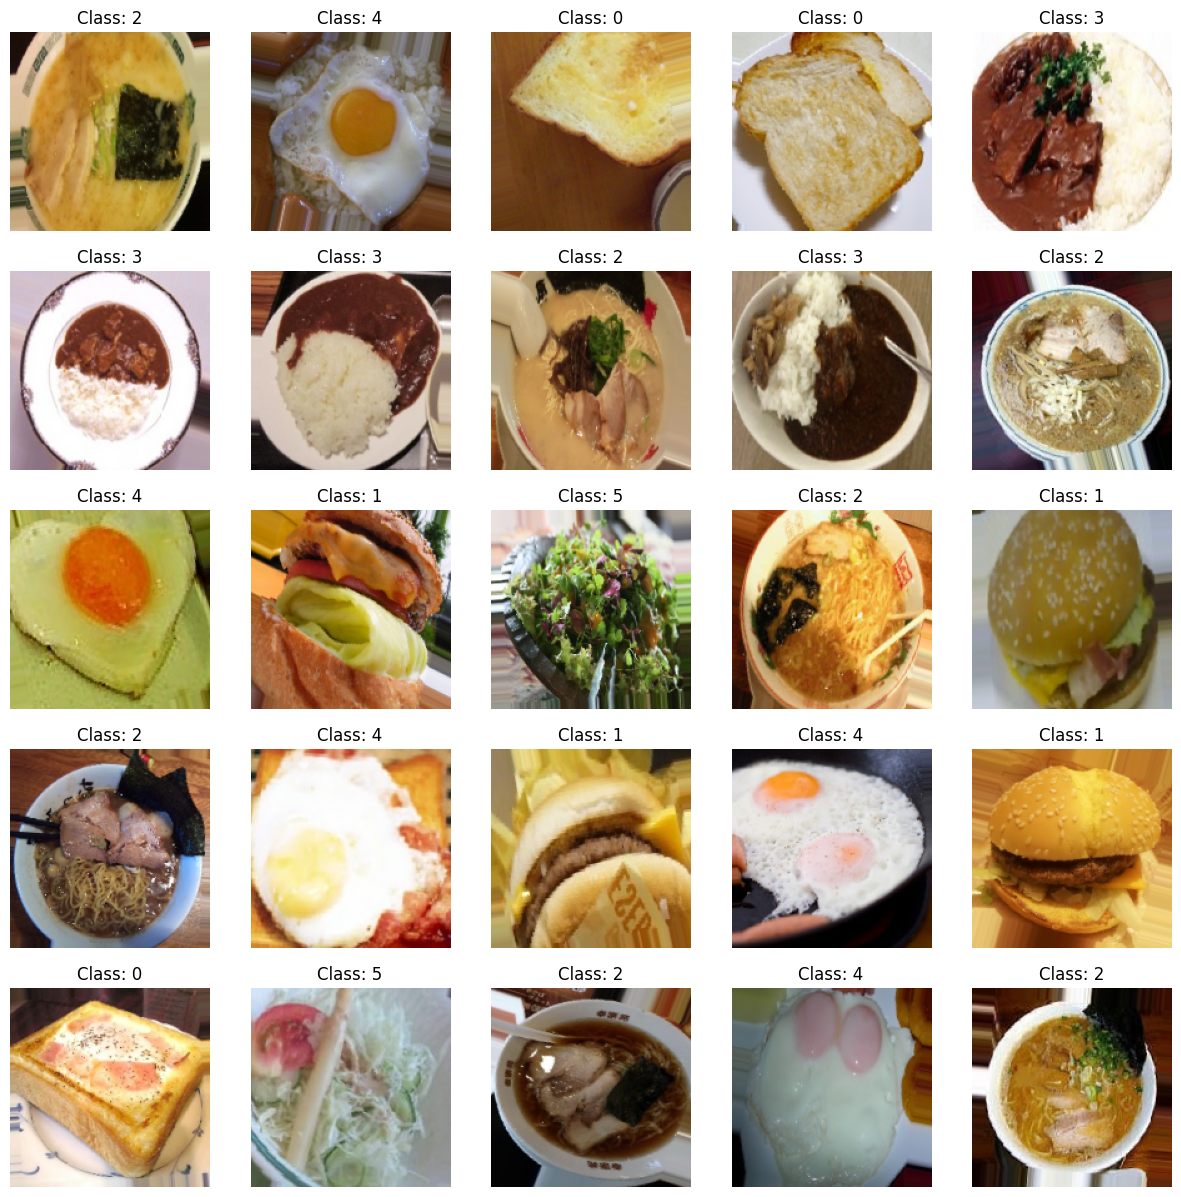

In [8]:
images, labels = next(train_data)

num_images = 25
plt.figure(figsize=(15, 15))

# Loop through and display the images
for i in range(num_images):
    plt.subplot(5, 5, i + 1)  # Create a 5x5 grid of subplots
    plt.imshow(images[i])  # Display the image
    plt.title(f"Class: {labels[i].argmax()}")  # Show class label
    plt.axis("off")  # Hide axis for cleaner look

plt.show()


In [9]:
print("Pixel values range:", images[0].min(), "to", images[0].max())

Pixel values range: 0.0 to 0.9737178


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(160, 160, 3)),

    # First Convolution Block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second Convolution Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Third Convolution Block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Fourth Convolution Block
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Global Average Pooling to reduce the size of the output
    tf.keras.layers.GlobalAveragePooling2D(),

    # Fully Connected Layers with more neurons to increase parameters
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(6, activation='softmax')  # Match the number of classes
])


# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.7,
    patience=3,
    min_lr=1e-6
)

# Compile the model with additional metrics: Precision, Recall, and F1-Score
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 158, 158, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 79, 79, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 77, 77, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 36, 36, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,082,438 (7.94 MB)

 Trainable params: 2,082,438 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.1948 - loss: 1.7797 - val_accuracy: 0.2438 - val_loss: 1.6800 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.2866 - loss: 1.6650 - val_accuracy: 0.4406 - val_loss: 1.4564 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 445ms/step - accuracy: 0.3924 - loss: 1.5138 - val_accuracy: 0.4656 - val_loss: 1.3928 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 0.4508 - loss: 1.4039 - val_accuracy: 0.3906 - val_loss: 1.4174 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step - accuracy: 0.4556 - loss: 1.3635 - val_accuracy: 0.3938 - val_loss: 1.5455 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - accuracy: 0.4461 - loss: 1.4010 - val_accuracy: 0.5531 - val_loss: 1.2813 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.5228 - loss: 1.2330 - val_acc

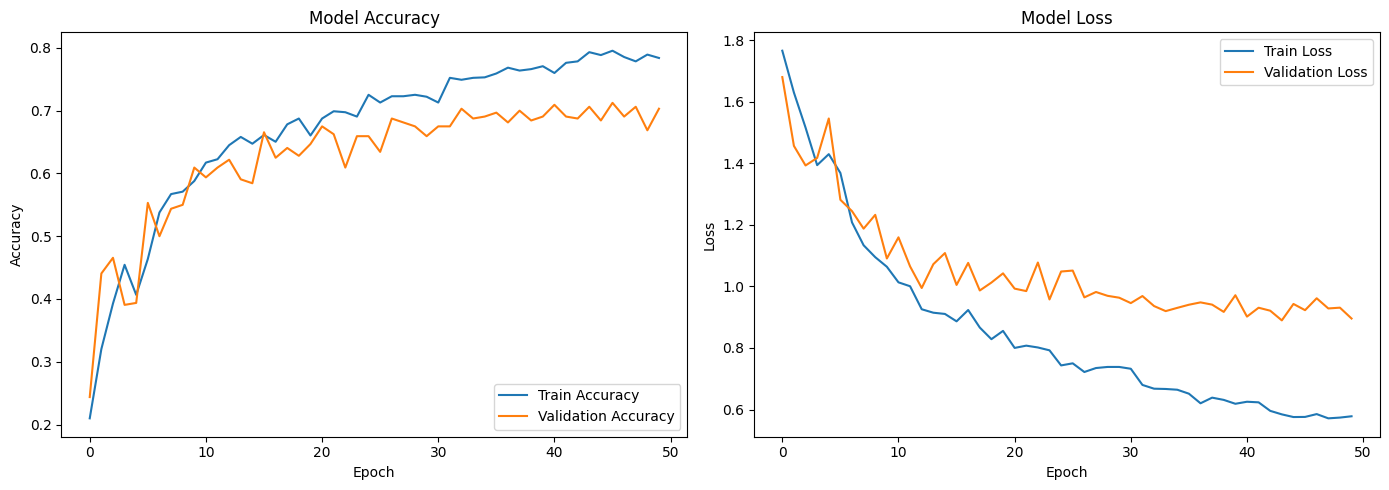

In [12]:
# Plot training & validation accuracy values
#split data 0.2/0.8
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

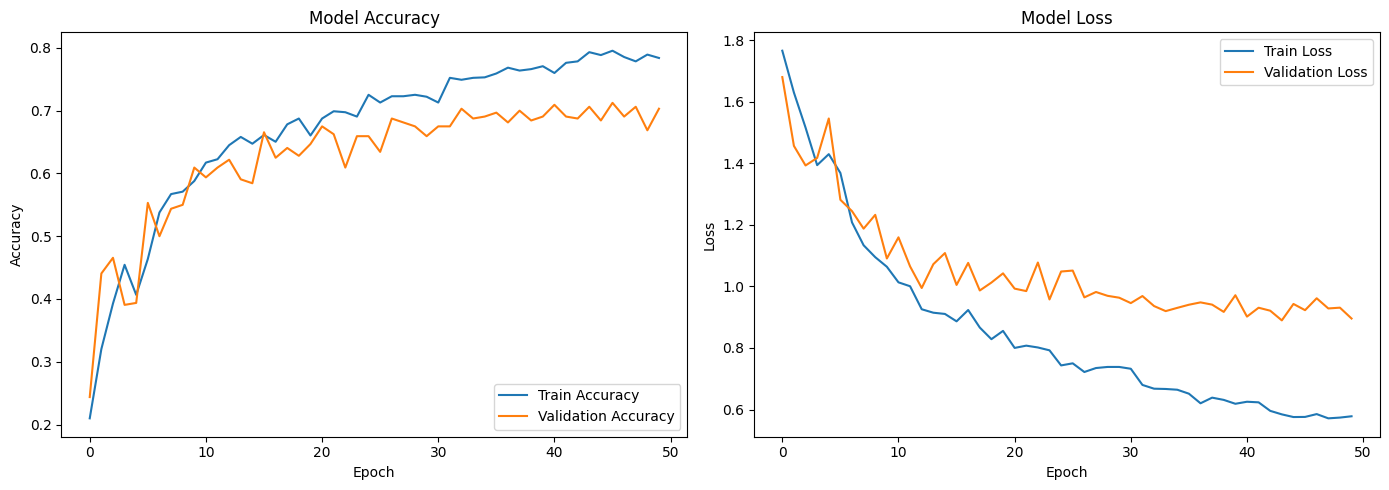

In [13]:
# Plot training & validation accuracy values
#split data 0.2/0.8
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [14]:
model.save('/content/model/foodmodel.h5')

In [3]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

uploaded = files.upload()

# Step 2: Load your model
model = load_model('/content/model/foodmodel.h5')

for img_name in uploaded.keys():
    img_path = img_name  # This is the name of the uploaded image
    img = image.load_img(img_path, target_size=(150, 150))  # Resize according to your model input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize (if you did normalization during training)

    # Step 4: Make predictions
    prediction = model.predict(img_array)

    # Step 5: Print the predicted class
    predicted_class = np.argmax(prediction, axis=1)
    print(f"Predicted class: {predicted_class}")


ModuleNotFoundError: No module named 'google'

{'12': 0, 'burger': 1, '23': 2, '6': 3, '68': 4, '87': 5}